In [1]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch

# imports to load some data
from fours.utils.data_handling import load_adi_data

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.photometry import flux_ratio2mag, mag2flux_ratio

from pynpoint.util.analysis import fake_planet

In [27]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from fours.models.rotation import FieldRotationModel


class PCANoiseModel(nn.Module):

    def __init__(
            self,
            angles: np.ndarray,
            image_shape: int,
            pca_number: int,
            approx_svd: int = -1
    ):
        super(PCANoiseModel, self).__init__()

        # save the simple parameters
        self.m_pca_number = pca_number
        self.m_approx_svd = approx_svd
        self.m_image_shape = image_shape

        # create the rotation model
        self.rotation_model = FieldRotationModel(
            all_angles=angles,
            input_size=self.m_image_shape,
            subsample=1,
            inverse=False,
            register_grid=True)

    def compute_basis(
            self,
            images):

        if self.m_approx_svd == -1:
            _, _, basis = torch.linalg.svd(images)
            basis = basis.T
        else:
            _, _, basis = torch.svd_lowrank(
                images, niter=1, q=self.m_approx_svd)

        return basis

    def forward(self, images):
        # 1.) reshape images to fit for PCA
        images = images.view(images.shape[0],
                             images.shape[1] * images.shape[2])

        # 2.) remove the mean as needed for PCA
        images = images - images.mean(dim=0)

        # 3.) compute PCA basis
        basis = self.compute_basis(images)

        # 4.) compute PCA residuals
        pca_rep = torch.matmul(images, basis[:, :self.m_pca_number])
        noise_estimate = torch.matmul(pca_rep, basis[:, :self.m_pca_number].T)
        residual = images - noise_estimate
        residual_sequence = residual.view(
            images.shape[0],
            self.m_image_shape,
            self.m_image_shape)

        # 5.) rotate the frames
        rotated_frames = self.rotation_model(
            residual_sequence.unsqueeze(1).float(),
            parang_idx=torch.arange(len(residual_sequence))).squeeze(1)

        # 6.) average along the time axis
        return rotated_frames.mean(dim=0)


# Load the data

In [2]:
dataset_file = Path("/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/09_new_rotation_loss/x2_different_residual_creations/")
exp_id = str("0123a")
use_rotation_loss = True
lambda_reg = float(850)

In [3]:
science_data, angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=str(dataset_file),
        data_tag="object_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

# other parameters
dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale = 0.02718

# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

In [4]:
dataset_id = "0115b"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + exp_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [5]:
fake_planet_config

{'type': 'TP estimation',
 'flux_ratio': 0.00025118864315095795,
 'separation': 9.0,
 'planet_position': [54.0, 45.0, 9.0, 0.0],
 'exp_id': '0123a'}

In [6]:
fake_planet_config["flux_ratio"] = mag2flux_ratio(9.5)
fake_planet_config["separation"] = 15
fake_planet_config["planet_position"] = [0., 0., 15., 0.]

In [7]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template,
    parang=angles - np.pi/2, # the pi/2 is to correct the parang to the north
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

# Run the PCA

In [38]:
pca_model = PCANoiseModel(
    angles=angles,
    image_shape=science_data.shape[1],
    pca_number=50,
    approx_svd=5000)

In [39]:
science_data_torch = torch.tensor(data_with_fake_planet, dtype=torch.float32)

In [40]:
# move to GPU
if torch.cuda.is_available():
    pca_model = pca_model.cuda()
    science_data_torch = science_data_torch.cuda()

In [41]:
residual_frame = pca_model(science_data_torch)

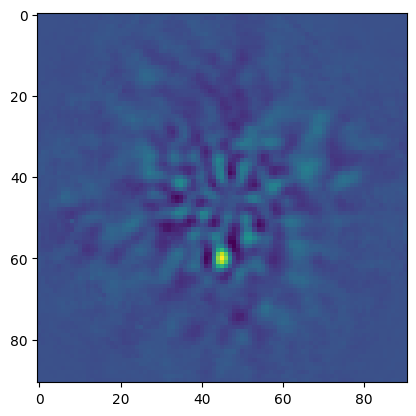

In [42]:
plt.imshow(residual_frame.cpu().detach().numpy())